# Prevedere l'età del granchio in base ai suoi attributi fisici

Progetto di Programmazione di Applicazioni Data Intensive 2023/2024

**Realizzato da:** Simone Bollini<br/>
simone.bollini@studio.unibo.it mat. 975149

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Dichiaro fin da subito le costanti per parametrizzare la parte di dati del set che sarà utilizzato come test

In [90]:
_RANDOM_STATE = 18
_TEST_SIZE = 1/3

## Intro

- Il set è utilizzato per stimare l'età del granchio in base agli attributi fisici.
Oltre una certa età, c'è una crescita trascurabile delle caratteristiche fisiche del granchio e, quindi, è importante individuare l'età per ridurre i costi e aumentare i profitti..

## Estrazione dati

Il dataset puo essere scaricato da [Kaggle](https://www.kaggle.com/datasets/sidhus/crab-age-prediction/data) 

In [91]:
import os.path
from urllib.request import urlretrieve
if not os.path.exists("crab.zip"):
    urlretrieve("https://github.com/ilBollo/DataIntensive_Project_Crab/raw/master/crab.zip", "crab.zip")


In [92]:
dataC = pd.read_csv("crab.zip", sep=",", compression="zip")
dataC.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


### Significato delle colonne
Le feature presenti nel dataset sono: 
- `Sex`: sesso del granchio. Possibili valori: Female, Male o Indeterminate
- `Length`: Lunghezza del granchio (in piedi; 1 piede = 30,48 cm)
- `Diameter`: Diametro del granchio (in piedi)
- `Height`: Altezza del granchio (in piedi)
- `Weight`: Peso del granchio (in once; 1 oncia = 28,35 g)
- `Shucked Weight`: Peso senza guscio (in once)
- `Viscera Weight`: è il peso della parte che avvolge gli organi addominali nel granchio (in once)
- `Shell Weight`: Peso della conchiglia (in once)
- `Age`: Età del granchio (in mesi)

La variabile che tenteremo di predirre è l'età del granchio.

In [93]:
dataC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3893 non-null   object 
 1   Length          3893 non-null   float64
 2   Diameter        3893 non-null   float64
 3   Height          3893 non-null   float64
 4   Weight          3893 non-null   float64
 5   Shucked Weight  3893 non-null   float64
 6   Viscera Weight  3893 non-null   float64
 7   Shell Weight    3893 non-null   float64
 8   Age             3893 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 273.9+ KB


la colonna sex contiene solo i valori "F", "M" e "I" per questo motivo occupa troppo spazio come object ricarichiamo la colonna con tipo category per ottimizzare il consumo di memoria

In [94]:
dataC = pd.read_csv("crab.zip", sep=",", compression="zip", dtype={"Sex":"category"})

In [95]:
dataC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Sex             3893 non-null   category
 1   Length          3893 non-null   float64 
 2   Diameter        3893 non-null   float64 
 3   Height          3893 non-null   float64 
 4   Weight          3893 non-null   float64 
 5   Shucked Weight  3893 non-null   float64 
 6   Viscera Weight  3893 non-null   float64 
 7   Shell Weight    3893 non-null   float64 
 8   Age             3893 non-null   int64   
dtypes: category(1), float64(7), int64(1)
memory usage: 247.4 KB


anche se il dataset non è molto grande solo questa piccola correzione ha ridotto l'uso di memoria quasi del 10%

## Analisi generale dei dati

Creiamo due variabili per utilizzare le feature divise per tipo

In [96]:
numeric_vars = ["Length",	"Diameter",	"Height",	"Weight",	"Shucked Weight",	"Viscera Weight",	"Shell Weight"]
categorical_vars = ["Sex"]

Visualizziamo alcune statistiche per comprendere le caratteristiche del dataset:

Vediamo come prima cosa quanto variano i dati in nostro possesso:

In [97]:
for col in numeric_vars:
    if col in dataC.columns:
        print(col + ": \t" + str(dataC[col].nunique()))

Length: 	134
Diameter: 	111
Height: 	51
Weight: 	2343
Shucked Weight: 	1482
Viscera Weight: 	867
Shell Weight: 	907


Ora eseguiamo un'analisi di base dei dati, iniziamo visualizzando la distribuzione dell'età dei granchi nel set. 

In [98]:
dataC["Age"].value_counts().sort_index()

Age
1       1
2       1
3      13
4      53
5     107
6     241
7     357
8     520
9     640
10    598
11    459
12    248
13    195
14    122
15     96
16     62
17     54
18     38
19     31
20     23
21     14
22      6
23      7
24      2
25      1
26      1
27      2
29      1
Name: count, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x1a4eb32c110>,
 'caps': [<matplotlib.lines.Line2D at 0x1a4eb32dc10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a4eb325ed0>],
 'medians': [<matplotlib.lines.Line2D at 0x1a4eb32d890>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a4eb32ce90>],
 'means': [<matplotlib.lines.Line2D at 0x1a4eb32e610>]}

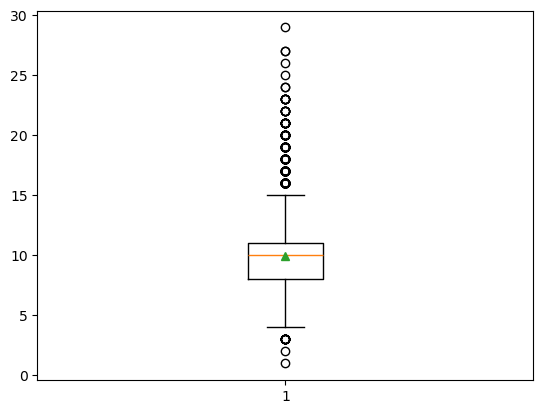

In [99]:
plt.boxplot(dataC["Age"],showmeans=True)

la distribuzione dei non è omogenea soprattutto per granchi sotto i 3 mesi e sopra i 23 mesi i dati sono pochi. Questo mostra un età media di vita dei granchi compresa tra i 5 e 15 anno.
Andiamo ora ad analizzare  nel dettaglio la distribuzione delle altre feature.

In [100]:
dataC.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000
mean,1.311306,1.020893,0.349374,23.567275,10.207342,5.136546,6.795844,9.954791
std,0.300431,0.248233,0.104976,13.891201,6.275275,3.104133,3.943392,3.220967
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,1.125000,0.875000,0.287500,12.672227,5.343881,2.664853,3.713785,8.000000
50%,1.362500,1.062500,0.362500,22.792998,9.539607,4.861939,6.662133,10.000000
75%,1.537500,1.200000,0.412500,32.786197,14.273973,7.200773,9.355335,11.000000
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


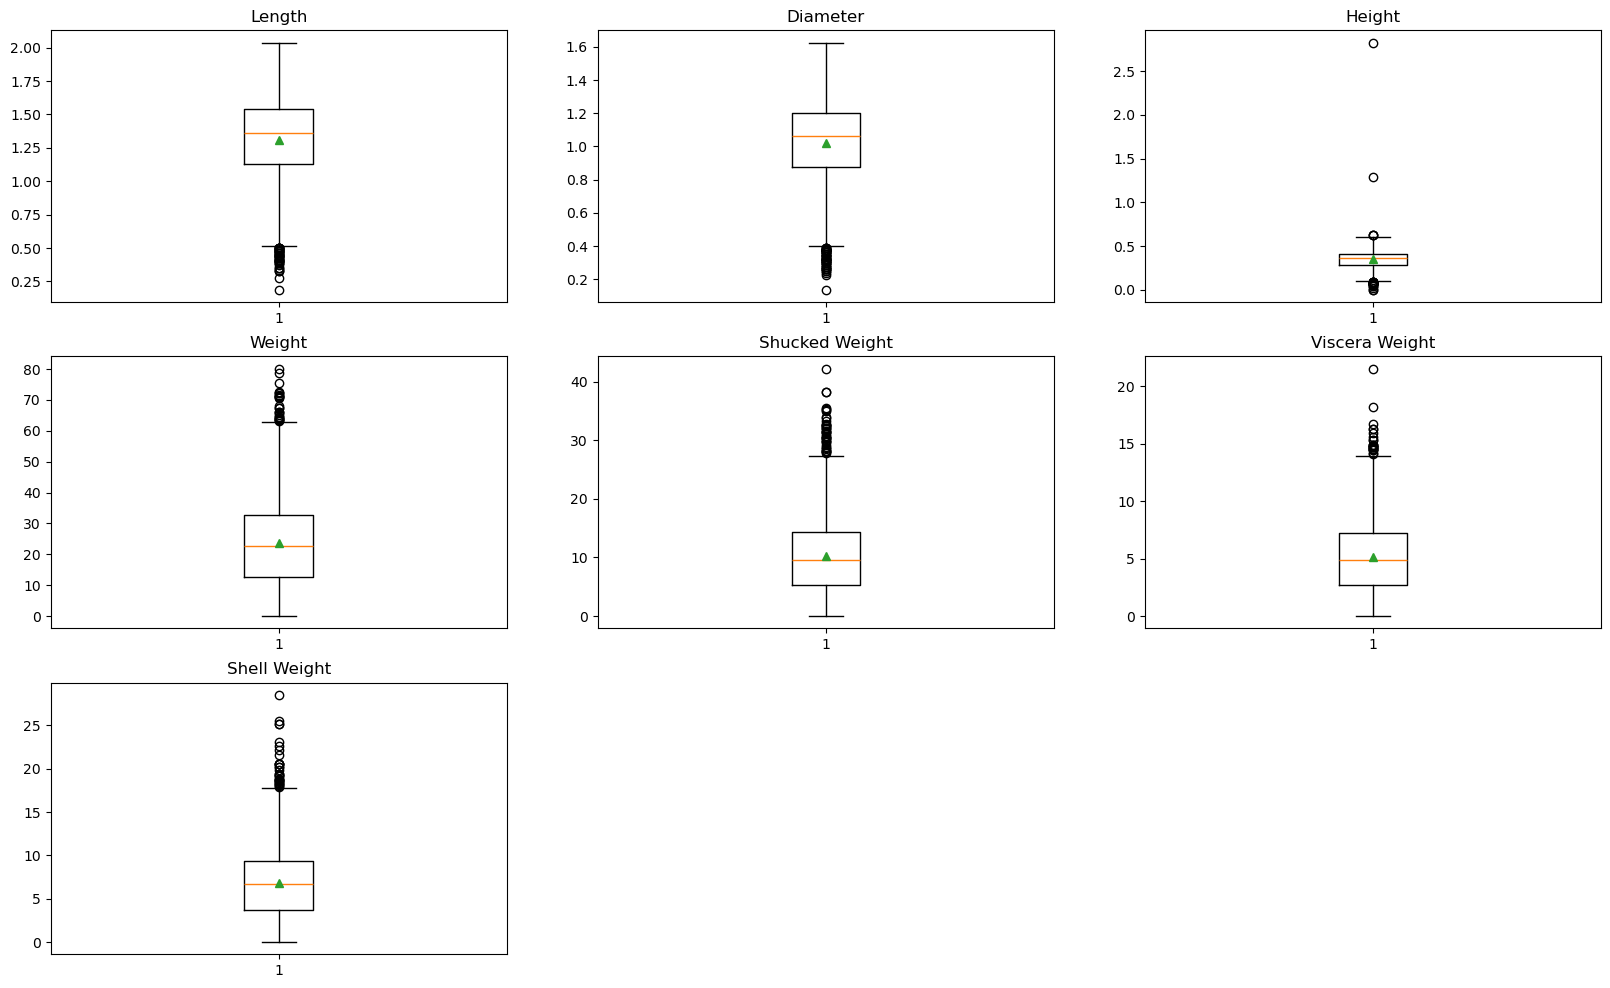

In [101]:
plt.figure(figsize=(20, 12))
for i, col in enumerate(numeric_vars,start=1):
    plt.subplot(3,3,i,title=col).boxplot(dataC[col],showmeans=True);

Dai grafici si nota che per tutte le feature sono presenti dati molto distanti dalla mediana

### sesso del granchio

In [102]:
dataC["Sex"].value_counts().sort_index()

Sex
F    1225
I    1233
M    1435
Name: count, dtype: int64

Sono presenti quasi un terzo di granchi senza il sesso determinato questo rende più difficile la predizione

### Correlazione tra i dati
Si procede a verificare come i dati numerici siano legati all'età dei granchi

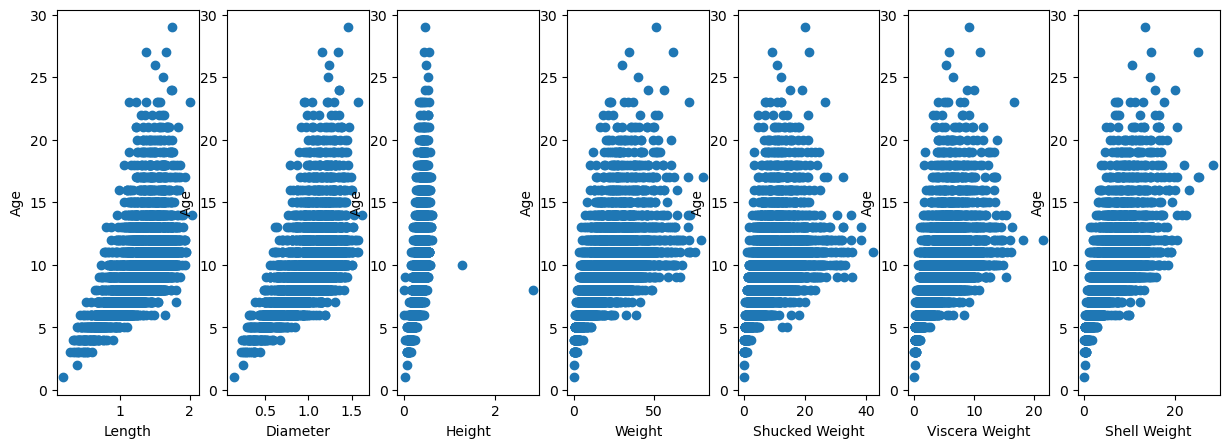

In [103]:
def age_on_numerical_subplot(dataC,x, y, columns):
    n = len(columns)
    plt.figure(figsize=(15,5))
    for i in range(0,n):
      plt.subplot(x, y, i+1)
      plt.scatter(dataC[columns[i]], dataC["Age"] )
      plt.xlabel(columns[i])
      plt.ylabel("Age")

age_on_numerical_subplot(dataC, 1, len(numeric_vars),numeric_vars)

come ci si aspetta al crescere delle dimensioni cresce l'età del granchio **ma questo accade con una certa regolarità fino al 10 mese**, alcuni valori successivamente **decrescono**. Inoltre vediamo per l'altezza ci sono dei valori che si discostano completamente da quelli in una crescita regolare andremo quindi ad eliminarli.
Purtroppo a parità di età di dati si distribuisco su un intervallo molto grande, l'unico dato che subisce in maniera inferiore questa situazione è l'altezza

In [104]:
dataC[(dataC['Age'] == 10) & (dataC['Sex'] =='M')][['Weight', 'Age']].head(10)

,Weight,Age
7,23.572609,10
16,37.237068,10
43,34.047750,10
73,33.112216,10
98,42.807745,10
114,24.834162,10
121,33.594158,10
147,49.313955,10
172,29.058238,10
174,15.960769,10


qui sopra è subito visibile l'oscillazione di peso presente tra 10 granchi di 10 mesi e tutti maschi

## Correlazione tra i vari sottotipi di weight
Ci chiediamo se la variabile Weight è la somma di 'Shucked Weight' + ' Viscera Weigh' + '  Shell Weig'? verifichiamo:ht

In [105]:
dataTestWeight = dataC.copy()

In [106]:
dataTestWeight['diffpesi']=dataC['Weight'] - dataC['Shucked Weight'] - dataC['Viscera Weight'] - dataC['Shell Weight'] 

In [107]:
dataTestWeight['diffpesi'].head(10)

0   -0.028350
1    0.170097
2    0.354369
3    1.204854
4    0.255146
5    1.091456
6    0.935534
7    1.133980
8    1.927766
9    0.396893
Name: diffpesi, dtype: float64

Text(0, 0.5, 'Age')

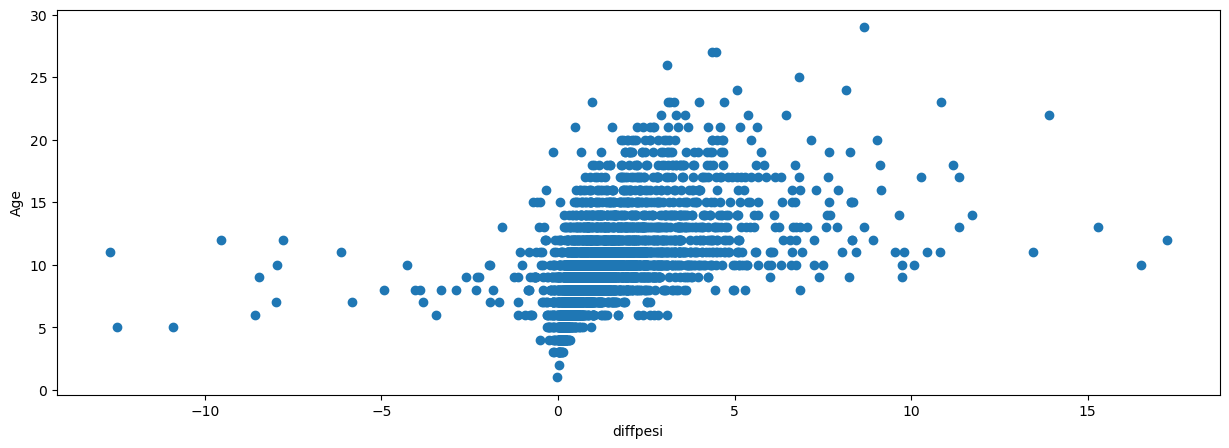

In [108]:
plt.figure(figsize=(15,5))
plt.scatter(dataTestWeight["diffpesi"], dataTestWeight["Age"] )
plt.xlabel("diffpesi")
plt.ylabel("Age")

purtroppo questa diffenza non sempra avvere una correlazione significativa con l'età del granchio.
**Non  aggiungiamo quindi questa feature al Dataset**

# Preprocessamento
Eliminiamo i valori estremi  di height, e Viscera Weight



In [109]:
(dataC["Height"] > 0.7).sum()

2

In [110]:
(dataC["Viscera Weight"] > 18).sum()

2

In [111]:
dataC = dataC[(dataC["Height"] <= 0.7) & (dataC["Viscera Weight"] <= 18)]

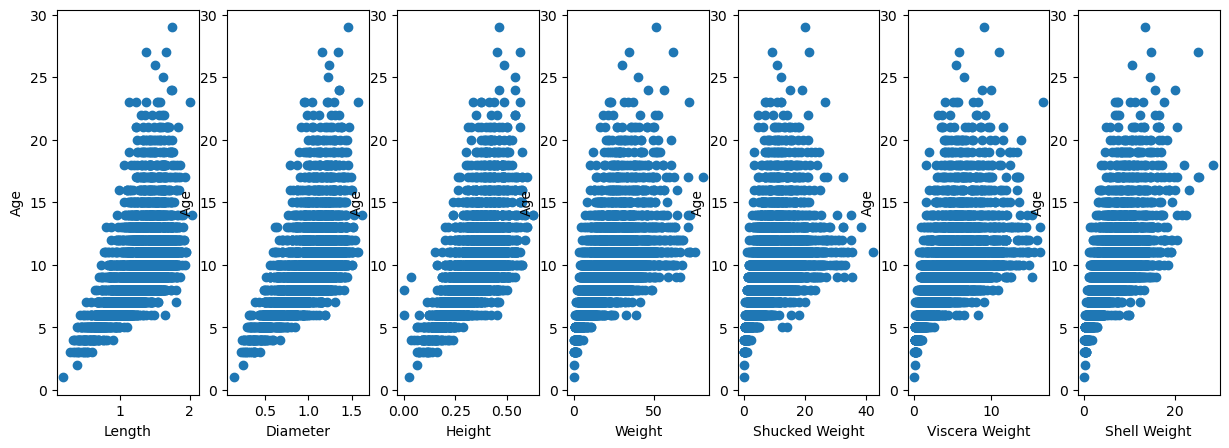

In [112]:
age_on_numerical_subplot(dataC, 1, len(numeric_vars), numeric_vars)

In [113]:
dataC.shape

(3889, 9)

Gestione variabile 'Sex'

In [114]:
dataC["Sex"].unique()

['F', 'M', 'I']
Categories (3, object): ['F', 'I', 'M']

La variabile categoriaca "Sex" la convertiamo in formato numerico con codifica binaria "One-Hot"

In [115]:
from sklearn.preprocessing import OneHotEncoder

In [116]:
encoder = OneHotEncoder(drop="first", sparse_output=False)
encorder_r = pd.DataFrame(
   encoder.fit_transform(dataC[["Sex"]]),
   columns=encoder.get_feature_names_out(["Sex"])
)

In [117]:
dataC = pd.concat([dataC.drop(columns=["Sex"]), encorder_r], axis=1)

In [118]:
dataC[dataC.isna().any(axis=1)]

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_I,Sex_M
3889,1.5500,1.2125,0.4375,34.458817,15.450477,7.172423,9.780577,10.0,NaN,NaN
3890,0.6250,0.4625,0.1625,2.012815,0.765436,0.524466,0.637864,5.0,NaN,NaN
3891,1.0625,0.7750,0.2625,10.347568,4.507570,2.338834,2.976698,6.0,NaN,NaN
3892,0.7875,0.6125,0.2125,4.068153,1.502523,1.346601,1.417475,8.0,NaN,NaN
748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
1757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0


In [119]:
dataC.dropna(inplace=True)

In [120]:
dataC.filter(like="Sex").head()

,Sex_I,Sex_M
0,0.0,0.0
1,0.0,1.0
2,1.0,0.0
3,0.0,0.0
4,1.0,0.0


questa soluzione elimina una colonna ed esegue una correlazione migliore

si procede ad isolare la colonna Age e a dividere i dati in training e validation set con il metodo **hold-out**.

In [121]:
from sklearn.model_selection import train_test_split
x = dataC.drop(columns="Age")
y = dataC["Age"]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=_TEST_SIZE, random_state=_RANDOM_STATE)

## Analisi coefficienti modelli


 
uso la funzione print_eval vista a lezione per calcolare e stampare le metriche d'errore:
  - l'_errore relativo_, che indica intuitivamente la percentuale di errore del modello
  - l'_errore quadratico medio_, usato nella discesa del gradiente ma più difficilmente interpretabile
  - il _coefficiente R²_, che esprime l'accuratezza con un indice tra 0 e 1
  - _Root Mean Squared Percentage Error_ (RMSPE), usato nella competizione Kaggle come misura di riferimento
$$ \textrm{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{y_i - \hat{y}_i}{y_i}\right)^2} $$
- Definiamo una funzione `rmspe` per calcolare tale metrica dati i valori attesi e le predizioni

In [122]:
# MSE e R^2 sono incluse in scikit-learn
from sklearn.metrics import mean_squared_error, r2_score

# definisco l'errore relativo
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def rmspe(y_real, y_pred):
    return np.sqrt(np.mean((y_pred /y_real - 1) ** 2))

def print_eval(X, y, model):
    y_pred = model.predict(X)
    print(f" errRelat: {relative_error(y, y_pred):12.4f}")
    print(f"      MSE: {mean_squared_error(y, y_pred):12.4f}")
    print(f"R-2 Score: {r2_score(y, y_pred):12.4f}")
    print(f"    RMSPE: {rmspe(y, y_pred):12.4f}")

In [123]:
save_score = {}

## Modelli
eseguo qualche prima prova esporativa per verificare i coefficienti

In [124]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
model_a = LinearRegression()
model_a.fit(x_train, y_train)
print_eval(x_val, y_val, model_a)

 errRelat:       0.1522
      MSE:       4.6792
R-2 Score:       0.5448
    RMSPE:       0.1947


In [125]:
model_b = Ridge(alpha=1)
model_b.fit(x_train, y_train)
print_eval(x_val, y_val, model_b)

 errRelat:       0.1525
      MSE:       4.6868
R-2 Score:       0.5441
    RMSPE:       0.1954


- Visualizziamo i coefficienti dei modelli:

In [126]:
pd.DataFrame({
    "linear": model_a.coef_,
    "ridge": model_b.coef_
}, index=x.columns)

,linear,ridge
Length,-0.404835,0.326053
Diameter,4.375285,3.834234
Height,10.135355,8.056977
Weight,0.292027,0.294323
Shucked Weight,-0.665378,-0.671231
Viscera Weight,-0.376899,-0.367982
Shell Weight,0.276472,0.296250
Sex_I,-0.009257,-0.011413
Sex_M,0.129125,0.132144


Da questo momento al nostro dataframe applicheremo sempre un filtro StandardScaler per standarizzare i dati essendo relativi a scale diverse

## Regressione Lasso
Testiamo ora la Regressione Lasso dove le variabili meno importanti vengono eliminate.
Creiamo una pipeline e facciamo partire la grid search che testa il modello in 5-cross fold validation secondo il set di iperparametri che gli chiediamo di valutare.


In [127]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
modelLas = Pipeline([
    ("scale", StandardScaler()),
    ("regr", Lasso())
])
grid = {
    "regr__alpha":  [0.1, 1, 10]
}
gs = GridSearchCV(modelLas, grid, cv=5)
gs.fit(x_train, y_train)
sel = ["rank_test_score","mean_test_score","std_test_score","params"]
pd.DataFrame(gs.cv_results_)[sel]

,rank_test_score,mean_test_score,std_test_score,params
0,1,0.483900,0.011219,{'regr__alpha': 0.1}
1,2,0.298546,0.005931,{'regr__alpha': 1}
2,3,-0.000365,0.000552,{'regr__alpha': 10}


Scegliamo quindi il parametro più piccolo perché vediamo che l'accuratezza crolla con una regolarizzazione più forte e addestriamo un modello allo scopo di individuare le feature più rilevanti.

In [128]:
modelLas = Pipeline([
    ("scale",  StandardScaler(with_mean=False)),
    ("linreg", Lasso(alpha=0.1))
])
modelLas.fit(x_train, y_train);

In [129]:
pd.Series(modelLas.named_steps["linreg"].coef_, x.columns)

Length            0.000000
Diameter          0.333318
Height            0.974386
Weight            0.000000
Shucked Weight   -1.403476
Viscera Weight   -0.000000
Shell Weight      1.978978
Sex_I            -0.000000
Sex_M             0.000000
dtype: float64

In [130]:
print_eval(x_val, y_val, modelLas)

 errRelat:       0.1590
      MSE:       5.1621
R-2 Score:       0.4979
    RMSPE:       0.2058


l'errore è maggiore di quello ottenuto nei precedenti modelli fatti a puro scopo esplorativo.
Quindi anche se non tutte le feature sono ugualmente rilevanti è difficile selezionarne un gruppo ristretto e avere comunque una precisione accettabile.

In [131]:
save_score['Lasso'] = modelLas.score(x_val, y_val)

## Regressione Ridge

Testiamo ora il modello di regressione Ridge, modello di regressione lineare applicando però una regolarizzazione per evitare che i coefficienti crescano troppo. Sotto abbiamo visto che usando PolynomialFeatures di grado 2 il modello migliora.

In [132]:
from sklearn.linear_model import Ridge
modelRid = Pipeline([
    ("poly",  PolynomialFeatures(2)),
    ("scale",  StandardScaler()),
    ("linreg", Ridge())
])
grid = {
    "linreg__alpha": [0.1, 1, 10, 50]
    }
gs = GridSearchCV(modelRid, param_grid=grid, cv=5)
gs.fit(x_train, y_train)
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

,rank_test_score,mean_test_score,std_test_score,params
1,1,0.547419,0.020306,{'linreg__alpha': 1}
0,2,0.544986,0.022746,{'linreg__alpha': 0.1}
2,3,0.542613,0.015023,{'linreg__alpha': 10}
3,4,0.524314,0.012504,{'linreg__alpha': 50}


Vediamo come il valore **alpha** che rappresenta il peso della regolarizzazione non modifica particolarmente i risultati ottenuti questo ci fa propendere verso l'idea che con la semplice regressione lineare si possa comunque raggiungere un risultato soddisfacente.

In [133]:
modelRid.fit(x_train, y_train)
modelRid.score(x_val, y_val)

0.5806039593600789

In [134]:
save_score['Ridge'] = modelRid.score(x_val, y_val)

## Regressione Lineare

In [135]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

linear_model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])

kf = KFold(5, shuffle=True, random_state=_RANDOM_STATE)
scores = cross_val_score(linear_model,x_train , y_train, cv=kf)
scores.mean()

0.5201901645005128

Vediamo come l'accuratezza raggiunta sia dopo più di quella della Regressione Ridge segno che la regolarizzazione non influisce in modo significativo sul risultato come previsto.

In [136]:
linear_model.fit(x_train, y_train)
linear_model.score(x_val, y_val)

0.5448365423268899

In [137]:
save_score['Linear'] = linear_model.score(x_val, y_val)

## Regressione Polinomiale

Il modello non è lineare vediamo se aggiungendo un certo grado con PolynomialFeatures l'accuratezza migliora

In [138]:
from sklearn.linear_model import Ridge
modLinearPol2 = Pipeline([
    ("poly",  PolynomialFeatures()),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
grid = {
    "poly__degree": [1,2, 3]
    }
gs = GridSearchCV(modLinearPol2, param_grid=grid, cv=5)
gs.fit(x_train, y_train)
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

,rank_test_score,mean_test_score,std_test_score,params
1,1,0.536081,0.028925,{'poly__degree': 2}
0,2,0.518450,0.013881,{'poly__degree': 1}
2,3,-0.596980,1.879727,{'poly__degree': 3}


Vediamo che il secondo grado è il migliore questo si poteva capire anche dall'analisi iniziale dove avevamo visto che diverse feature crescevano fino ad una certa età per poi addirittura scendere. Tuttavia il risultato ottenuto non è ancora soddisfacente

In [139]:
gs.score(x_val, y_val)

0.578280524612426

In [140]:
save_score['LinearPoly2'] = gs.score(x_val, y_val)

## Regressione con alberi
Gli alberi prendono decisioni basate su ciascuna variabile,
questo nel nostro caso dovrebbe migliorare la predizione.

In [141]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
modelDecision = DecisionTreeRegressor(max_depth=2,random_state=_RANDOM_STATE)
modelDecision.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=18)

In [142]:
column_names = x_train.columns

In [143]:
column_names

Index(['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'Sex_I', 'Sex_M'],
      dtype='object')

In [144]:
print(export_text(modelDecision, feature_names=list(column_names)))

|--- Shell Weight <= 4.36
|   |--- Shell Weight <= 1.32
|   |   |--- value: [5.33]
|   |--- Shell Weight >  1.32
|   |   |--- value: [7.93]
|--- Shell Weight >  4.36
|   |--- Shell Weight <= 11.04
|   |   |--- value: [10.58]
|   |--- Shell Weight >  11.04
|   |   |--- value: [12.86]



In [145]:
print_eval(x_val, y_val, modelDecision)

 errRelat:       0.1824
      MSE:       6.5255
R-2 Score:       0.3652
    RMSPE:       0.2299


In [146]:
grid = {
    "max_depth": range(2, 6),
    "min_samples_split": np.linspace(0.0001, 0.001, 20, dtype=float),
    "min_samples_leaf": range(2,5)
}

In [147]:
decgs = GridSearchCV(modelDecision, grid, cv=kf)
decgs.fit(x_train, y_train);
decgs.best_params_


{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 0.0001}

In [148]:
pd.DataFrame(decgs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

,rank_test_score,mean_test_score,std_test_score,params
198,1,0.439839,0.035633,"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s..."
189,1,0.439839,0.035633,"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s..."
197,1,0.439839,0.035633,"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s..."
196,1,0.439839,0.035633,"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s..."
195,1,0.439839,0.035633,"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s..."
...,...,...,...,...
36,181,0.351446,0.025402,"{'max_depth': 2, 'min_samples_leaf': 3, 'min_s..."
35,181,0.351446,0.025402,"{'max_depth': 2, 'min_samples_leaf': 3, 'min_s..."
34,181,0.351446,0.025402,"{'max_depth': 2, 'min_samples_leaf': 3, 'min_s..."
33,181,0.351446,0.025402,"{'max_depth': 2, 'min_samples_leaf': 3, 'min_s..."


In [149]:
decgs.score(x_val, y_val)

0.4708695827152648

In [150]:
save_score['DecisionTree'] = decgs.score(x_val, y_val)

## Random Forest
Addestro più alberi in un sottoinsieme delle feature, ci aspettiamo risultati migliori

In [151]:
from sklearn.ensemble import RandomForestRegressor

In [152]:
%%time
rfm = RandomForestRegressor(max_samples=0.2, max_features="sqrt", n_estimators=200, max_depth=None, n_jobs=-1)
rfm.fit(x_train, y_train)

CPU times: total: 750 ms
Wall time: 400 ms


RandomForestRegressor(max_features='sqrt', max_samples=0.2, n_estimators=200,
                      n_jobs=-1)

In [153]:
print_eval(x_val, y_val, rfm)

 errRelat:       0.1460
      MSE:       4.5239
R-2 Score:       0.5599
    RMSPE:       0.1861


In [154]:
rfm.score(x_val, y_val)

0.5599417229284906

In [155]:
pd.Series(rfm.feature_importances_, index=list(column_names)).sort_values(ascending=False)

Shell Weight      0.270490
Weight            0.142988
Height            0.129235
Shucked Weight    0.128786
Viscera Weight    0.111080
Diameter          0.110745
Length            0.084779
Sex_M             0.011655
Sex_I             0.010241
dtype: float64

la feature più importante è il peso della conchiglia

Si procede ad una ricerca degli iperparametri per migliorare l'indipendenza dai dati di addestramento; in particolare grazie all'iperparametro max_features che limita il numero di dati usati per la divisione di un nodo ad un sottoinsieme casuale delle colonne del training set.

In [156]:
len(x_train)

2590

In [157]:
from sklearn.model_selection import RandomizedSearchCV
rf_grid = {
    "max_depth": range(8, 15, 3),
    "min_samples_split": [5,9,12],
    "min_samples_leaf": [1,3,5],
    "n_estimators": [50],
    "max_features": range(1, 10)
}
rfgs = RandomizedSearchCV(rfm, rf_grid, n_iter=10, n_jobs=-1, cv=kf, random_state=_RANDOM_STATE)
rfgs.fit(x_train, y_train)
#rfgs = GridSearchCV(rfm, rf_grid, n_jobs=-1, cv=kf)
#rfgs.fit(x_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=18, shuffle=True),
                   estimator=RandomForestRegressor(max_features='sqrt',
                                                   max_samples=0.2,
                                                   n_estimators=200,
                                                   n_jobs=-1),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(8, 15, 3),
                                        'max_features': range(1, 10),
                                        'min_samples_leaf': [1, 3, 5],
                                        'min_samples_split': [5, 9, 12],
                                        'n_estimators': [50]},
                   random_state=18)

In [158]:
rfgs.score(x_val, y_val)

0.5686832295601012

In [159]:
save_score['RandomForest'] = rfgs.score(x_val, y_val)

In [160]:
pd.DataFrame(rfgs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

,rank_test_score,mean_test_score,std_test_score,params
5,1,0.523225,0.031141,"{'n_estimators': 50, 'min_samples_split': 12, ..."
8,2,0.522069,0.028485,"{'n_estimators': 50, 'min_samples_split': 9, '..."
3,3,0.521760,0.030085,"{'n_estimators': 50, 'min_samples_split': 9, '..."
9,4,0.521473,0.027449,"{'n_estimators': 50, 'min_samples_split': 12, ..."
2,5,0.520564,0.033424,"{'n_estimators': 50, 'min_samples_split': 5, '..."
7,6,0.520336,0.025636,"{'n_estimators': 50, 'min_samples_split': 12, ..."
0,7,0.518234,0.029254,"{'n_estimators': 50, 'min_samples_split': 12, ..."
1,8,0.516708,0.021466,"{'n_estimators': 50, 'min_samples_split': 5, '..."
6,9,0.510192,0.029869,"{'n_estimators': 50, 'min_samples_split': 12, ..."
4,10,0.496192,0.024699,"{'n_estimators': 50, 'min_samples_split': 9, '..."


## LightGBM: 
Gradient Boosted Machine

In [161]:
from lightgbm import LGBMRegressor

In [162]:
%%time
lgbm = LGBMRegressor()
lgbm.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 2590, number of used features: 9
[LightGBM] [Info] Start training from score 9.911583
CPU times: total: 172 ms
Wall time: 198 ms


LGBMRegressor()

In [163]:
print_eval(x_val, y_val, lgbm)

 errRelat:       0.1464
      MSE:       4.4839
R-2 Score:       0.5638
    RMSPE:       0.1898


In [164]:
lgbm.score(x_val, y_val)

0.5638355431539999

In [165]:
save_score['LightGBM'] = lgbm.score(x_val, y_val)

## XGBoost

- La libreria `xgboost` fornisce un'implementazione dell'omonimo algoritmo (_eXtreme Gradient Boosting_)

In [166]:
import xgboost
print(xgboost.__version__)

1.1.0


In [167]:
from xgboost import XGBRegressor

In [168]:
%%time
xgbm = XGBRegressor(objective='reg:squarederror', subsample=1.0, reg_lambda=2.0, reg_alpha=0.1, n_estimators=100, max_depth=3, learning_rate=0.2, colsample_bytree=1.0)
xgbm.fit(x_train, y_train)

CPU times: total: 281 ms
Wall time: 172 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.1, reg_lambda=2.0, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [169]:
print_eval(x_val, y_val, xgbm)

 errRelat:       0.1446
      MSE:       4.5240
R-2 Score:       0.5599
    RMSPE:       0.1865


In [170]:
xgbm.score(x_val, y_val)

0.5599389385978997

In [171]:
save_score['XGBoost'] = xgbm.score(x_val, y_val)

In [172]:
#xgbm = XGBRegressor(objective='reg:squarederror', n_estimators=200)

#param_dist = {
#    'n_estimators': [100, 200, 300],
#    'learning_rate': [0.01, 0.1, 0.2],
#    'max_depth': [3, 5, 7],
#    'subsample': [0.7, 0.8, 0.9, 1.0],
#    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
#    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
#    'reg_lambda': [0.5, 1.0, 1.5, 2.0]
#}

#random_search = RandomizedSearchCV(estimator=xgbm, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, random_state=42)
#random_search.fit(x_train, y_train)
#best_params = random_search.best_params_
#print("Migliori parametri trovati:", best_params)
#best_model = random_search.best_estimator_
#best_model.score(x_val, y_val)


# conclusioni

La predizione dell'età di un granchio non è un risultato facile.
Le feature non hanno una correlazione ottimale rispetto all'età ed è difficile trovare relazioni che rendano estremamente accurata la predizione.

In [173]:
scores = pd.DataFrame(save_score.items(), columns=['Model', 'Accuracy']).set_index('Model')
scores.sort_values(by='Accuracy', ascending=False)

,Accuracy
Model,
Ridge,0.580604
LinearPoly2,0.578281
RandomForest,0.568683
LightGBM,0.563836
XGBoost,0.559939
Linear,0.544837
Lasso,0.497869
DecisionTree,0.470870


La migliore accuratezza si ottiene con una regressione Lineare Ridge di grado 2. La regolarizzazione Ridge riduce il rischio di overfitting rispetto ad una semplice regressione polinomiale.<br/>
Il modello è moderatemente non lineare, si è visto questo anche in fase iniziale di analisi dei dati dove risultava già evidente che la crescita delle varie feature del granchio era legata all'età, ma solo fino ad un certo periodo per poi fermarsi. Purtroppo le feature hanno valori molto diversi all'interno della stessa età, questa distribuzione non permette di avere predizioni particolarmente precise. I modelli di predizione più complessi non sono risultati utili per migliorare la previsione, un modello lineare polinomiale con regolarizzazione è il migliore che ho trovato per valutare le relazioni presenti.